In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210609'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/경기도/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

4it [00:00, 235.25it/s]

(2459, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,경기도 용인기흥구 고매동 263-5,기흥단지로136번길 5,기흥현대빌라,175.25,333.39,50000,2,1996,22,2018-06-04,285.306705,25,연립다세대
1,경기도 용인기흥구 고매동 263-5,기흥단지로136번길 5,기흥현대빌라,175.25,333.39,42000,1,1996,22,2018-08-03,239.657632,25,연립다세대
2,경기도 용인기흥구 고매동 261-22,기흥단지로110번길 11-5,동남드림빌라트,207.63,197.86,45000,1,1990,28,2018-08-29,216.731686,31,연립다세대
3,경기도 용인기흥구 고매동 261-11,기흥단지로110번길 9,동남연립(드림빌라트),71.19,82.00,9500,1,1989,29,2018-06-20,133.445709,32,연립다세대
4,경기도 용인기흥구 고매동 702-3,농서로34번길 6,동산빌라1차,59.30,43.37,7100,3,1996,22,2018-07-05,119.730185,25,연립다세대


In [8]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [9]:
target_gu = '용인기흥구'
target_dong = '신갈동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 36 # in months

In [11]:
target_df = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(68, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
396,경기도 용인기흥구 신갈동 30-6,신구로53번길 10-2,미소 그랑쥬테,35.79,18.80,14900,3,2016,2,2018-06-27,416.317407,5,연립다세대,용인기흥구,신갈동
399,경기도 용인기흥구 신갈동 39-20,신갈로 94,빌폴라리스,47.61,25.76,21500,2,2017,1,2018-06-10,451.585801,4,연립다세대,용인기흥구,신갈동
401,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,68.56,34.71,22200,4,2018,0,2018-07-27,323.803967,3,연립다세대,용인기흥구,신갈동
402,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,69.11,34.98,25400,5,2018,0,2018-07-27,367.530025,3,연립다세대,용인기흥구,신갈동
403,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,59.73,30.24,19250,3,2018,0,2018-07-27,322.283610,3,연립다세대,용인기흥구,신갈동


In [12]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [13]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [14]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [15]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(68, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
396,경기도 용인기흥구 신갈동 30-6,신구로53번길 10-2,미소 그랑쥬테,35.79,18.80,14900,3,2016,2,2018-06-27,416.317407,5,연립다세대,용인기흥구,신갈동,505.845259,2021-03-01
399,경기도 용인기흥구 신갈동 39-20,신갈로 94,빌폴라리스,47.61,25.76,21500,2,2017,1,2018-06-10,451.585801,4,연립다세대,용인기흥구,신갈동,548.698019,2021-03-01
401,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,68.56,34.71,22200,4,2018,0,2018-07-27,323.803967,3,연립다세대,용인기흥구,신갈동,389.653298,2021-03-01
402,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,69.11,34.98,25400,5,2018,0,2018-07-27,367.530025,3,연립다세대,용인기흥구,신갈동,442.271561,2021-03-01
403,경기도 용인기흥구 신갈동 388-184,신갈로 127,샤인하우스,59.73,30.24,19250,3,2018,0,2018-07-27,322.283610,3,연립다세대,용인기흥구,신갈동,387.823757,2021-03-01


In [17]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [18]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,경기도 용인기흥구 신갈동 14-28,청담그랑쥬테(A동B동),5,59.70,2020-08-27,23000,385.259631,2021-03-01,414.026845,연립다세대
1,경기도 용인기흥구 신갈동 14-28,청담그랑쥬테(A동B동),5,57.60,2020-10-26,19500,338.541667,2021-03-01,356.937301,연립다세대
2,경기도 용인기흥구 신갈동 14-29,청담그랑쥬테(C동),5,56.23,2020-03-21,19800,352.125200,2021-03-01,397.875797,연립다세대
3,경기도 용인기흥구 신갈동 14-29,청담그랑쥬테(C동),5,56.23,2020-06-20,21000,373.466121,2021-03-01,406.465690,연립다세대
4,경기도 용인기흥구 신갈동 14-29,청담그랑쥬테(C동),5,56.23,2020-08-19,20500,364.574071,2021-03-01,391.796700,연립다세대


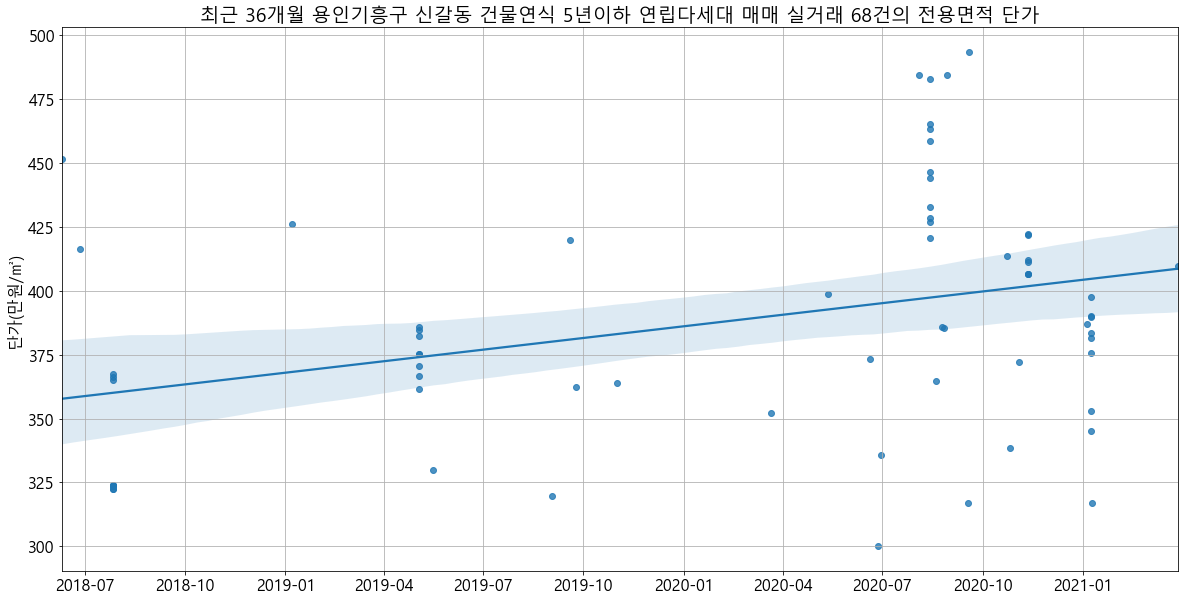

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [20]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

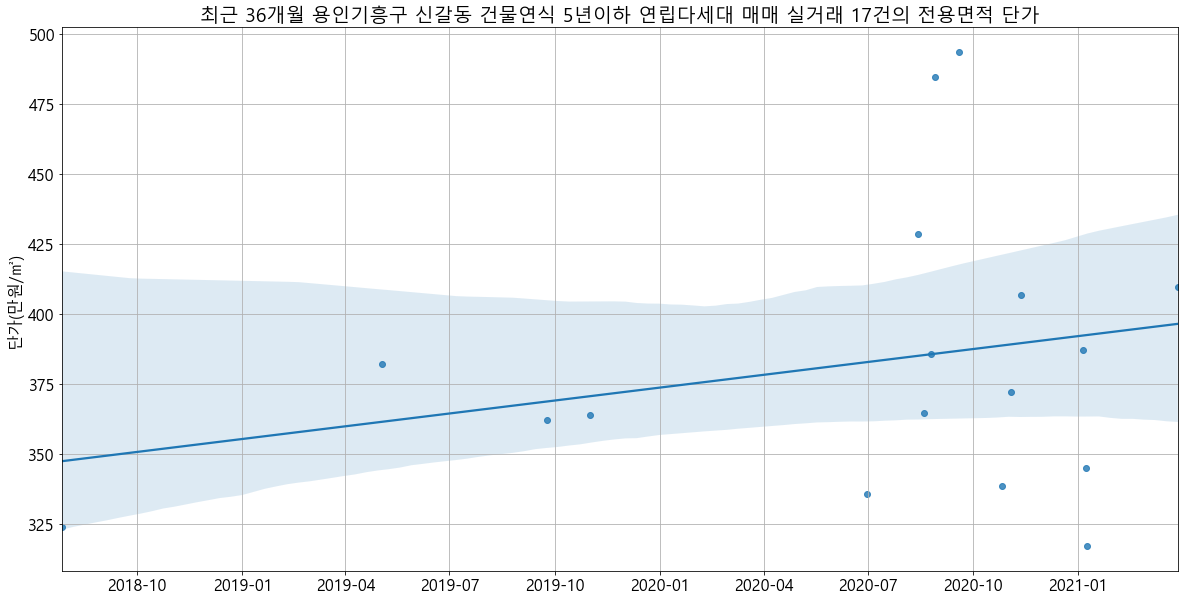

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [22]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [23]:
target_df2 = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(77, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
382,경기도 용인기흥구 신갈동 29-4,신구로53번길 16,골든하우스,43.33,32.12,14800,5,2014,4,2018-02-08,341.564736,7,연립다세대,용인기흥구,신갈동
383,경기도 용인기흥구 신갈동 331-9,신정로151번길 21-1,나비하우스(102동),44.66,31.86,13000,2,2014,4,2018-07-18,291.088222,7,연립다세대,용인기흥구,신갈동
396,경기도 용인기흥구 신갈동 30-6,신구로53번길 10-2,미소 그랑쥬테,35.79,18.80,14900,3,2016,2,2018-06-27,416.317407,5,연립다세대,용인기흥구,신갈동
397,경기도 용인기흥구 신갈동 39-20,신갈로 94,빌폴라리스,47.61,25.76,21000,3,2017,1,2018-01-02,441.083806,4,연립다세대,용인기흥구,신갈동
398,경기도 용인기흥구 신갈동 39-20,신갈로 94,빌폴라리스,47.61,25.76,19500,4,2017,1,2018-05-02,409.577820,4,연립다세대,용인기흥구,신갈동


In [24]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'용인기흥구 신갈동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 77건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

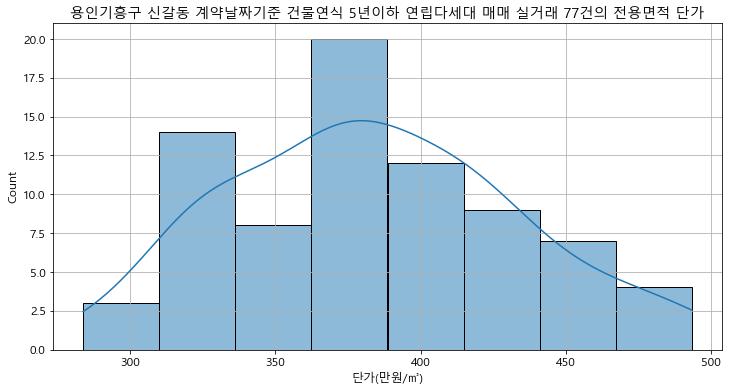

In [25]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(49, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,경기도 용인기흥구 신갈동 14-28,신갈로138번길 18,청담그랑쥬테(A동B동),57.60,31.49,19500,5,2016,4,2020-10-26,338.541667,5,연립다세대,용인기흥구,신갈동,356.937301,2021-03-01,361.900649,385.482073
1,경기도 용인기흥구 신갈동 14-28,신갈로138번길 18,청담그랑쥬테(A동B동),59.70,32.63,23000,4,2016,4,2020-08-27,385.259631,5,연립다세대,용인기흥구,신갈동,414.026845,2021-03-01,361.900649,385.482073
2,경기도 용인기흥구 신갈동 14-29,신갈로138번길 20,청담그랑쥬테(C동),56.23,28.17,20500,5,2016,4,2020-08-19,364.574071,5,연립다세대,용인기흥구,신갈동,391.796700,2021-03-01,364.574071,391.796700
3,경기도 용인기흥구 신갈동 14-6,신갈로138번길 16,청담그랑쥬테(1동2동3동),59.08,31.20,19250,2,2015,5,2020-10-26,325.829384,6,연립다세대,용인기흥구,신갈동,343.534259,2021-03-01,304.770500,324.215265
4,경기도 용인기흥구 신갈동 14-6,신갈로138번길 16,청담그랑쥬테(1동2동3동),59.92,31.60,17000,5,2015,5,2020-08-28,283.711615,6,연립다세대,용인기흥구,신갈동,304.896271,2021-03-01,304.770500,324.215265


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(22, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
1,경기도 용인기흥구 신갈동 14-28,신갈로138번길 18,청담그랑쥬테(A동B동),59.70,32.63,23000,4,2016,4,2020-08-27,385.259631,5,연립다세대,용인기흥구,신갈동,414.026845,2021-03-01,361.900649,385.482073
2,경기도 용인기흥구 신갈동 14-29,신갈로138번길 20,청담그랑쥬테(C동),56.23,28.17,20500,5,2016,4,2020-08-19,364.574071,5,연립다세대,용인기흥구,신갈동,391.796700,2021-03-01,364.574071,391.796700
4,경기도 용인기흥구 신갈동 14-6,신갈로138번길 16,청담그랑쥬테(1동2동3동),59.92,31.60,17000,5,2015,5,2020-08-28,283.711615,6,연립다세대,용인기흥구,신갈동,304.896271,2021-03-01,304.770500,324.215265
11,경기도 용인기흥구 신갈동 17-18,신갈로96번길 7,서리풀 신갈,59.16,33.85,27400,4,2020,0,2020-08-14,463.150778,1,연립다세대,용인기흥구,신갈동,497.734098,2021-03-01,453.581736,487.450540
13,경기도 용인기흥구 신갈동 17-20,신갈로96번길 5,이룸 그랑쥬테(17-20),60.99,32.50,19500,2,2017,2,2019-09-02,319.724545,4,연립다세대,용인기흥구,신갈동,370.232055,2021-03-01,340.983091,394.848855
14,경기도 용인기흥구 신갈동 17-25,신갈로96번길 3,이룸 그랑쥬테(17-25),44.60,24.60,17200,3,2017,3,2020-08-25,385.650224,4,연립다세대,용인기흥구,신갈동,414.446603,2021-03-01,385.650224,414.446603
16,경기도 용인기흥구 신갈동 29-4,신구로53번길 16,골든하우스,48.01,35.59,15800,2,2014,5,2019-01-18,329.098105,7,연립다세대,용인기흥구,신갈동,395.754637,2021-03-01,335.331420,409.684044
19,경기도 용인기흥구 신갈동 30-6,신구로53번길 10-2,미소 그랑쥬테,49.07,25.70,19000,2,2016,5,2021-01-05,387.201956,5,연립다세대,용인기흥구,신갈동,390.174096,2021-03-01,400.820976,447.409579
20,경기도 용인기흥구 신갈동 331-9,신정로151번길 21-1,나비하우스(102동),44.66,31.86,13000,2,2014,4,2018-07-18,291.088222,7,연립다세대,용인기흥구,신갈동,350.284422,2021-03-01,291.088222,350.284422
21,경기도 용인기흥구 신갈동 34-10,신구로43번길 18-1,그랑3657 (34-10),42.92,24.76,20800,3,2019,1,2020-08-29,484.622554,2,연립다세대,용인기흥구,신갈동,520.809165,2021-03-01,484.622554,520.809165


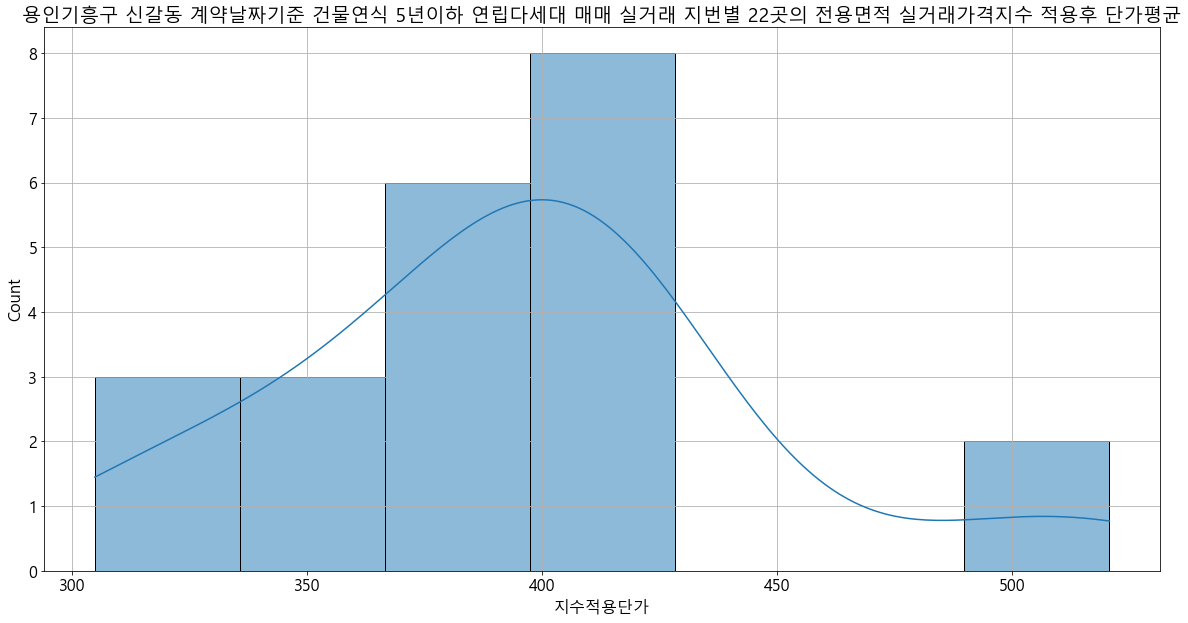

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,경기도 용인기흥구 신갈동 14-28,청담그랑쥬테(A동B동),2016,59.70,2020-08-27,385.259631,2021-03-01,414.026845,연립다세대
1,경기도 용인기흥구 신갈동 14-29,청담그랑쥬테(C동),2016,56.23,2020-08-19,364.574071,2021-03-01,391.796700,연립다세대
2,경기도 용인기흥구 신갈동 14-6,청담그랑쥬테(1동2동3동),2015,59.92,2020-08-28,283.711615,2021-03-01,304.896271,연립다세대
3,경기도 용인기흥구 신갈동 17-18,서리풀 신갈,2020,59.16,2020-08-14,463.150778,2021-03-01,497.734098,연립다세대
4,경기도 용인기흥구 신갈동 17-20,이룸 그랑쥬테(17-20),2017,60.99,2019-09-02,319.724545,2021-03-01,370.232055,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)